In [1]:
import os
import cv2
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths and categories
data_dir = 'C:/Users/dhill/VS-Code/dataset'
categories = ['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Function to apply Gaussian blur
def apply_gaussian_blur(image, ksize=(5, 5)):
    return cv2.GaussianBlur(image, ksize, 0)

# Function to apply histogram equalization
def apply_histogram_equalization(image):
    if len(image.shape) == 2:  # Grayscale image
        return cv2.equalizeHist(image)
    else:  # Color image
        ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)

# Function to adjust intensity thresholds
def adjust_intensity(image, low=0, high=255):
    return cv2.normalize(image, None, alpha=low, beta=high, norm_type=cv2.NORM_MINMAX)

# Function to load and preprocess images
def load_and_preprocess_images(data_dir, categories, img_size=(64,64), enhance=False):
    data = []
    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                if enhance:
                    # Apply Gaussian blur
                    img_array = apply_gaussian_blur(img_array)
                    # Apply histogram equalization
                    img_array = apply_histogram_equalization(img_array)
                    # Adjust intensity thresholds
                    img_array = adjust_intensity(img_array)
                resized_array = cv2.resize(img_array, img_size)
                data.append([resized_array, class_num])
            except Exception as e:
                print(f"Error processing {os.path.join(path, img)}: {str(e)}")
    return data

# Load and preprocess images
data = load_and_preprocess_images(data_dir, categories)

# Shuffle the data
random.shuffle(data)

# Select 1000 images for training and 200 images for testing
train_data = data[:1000]
test_data = data[1000:1200]

# Split data and labels for training and testing
X_train = np.array([entry[0] for entry in train_data])
y_train = np.array([entry[1] for entry in train_data])
X_test = np.array([entry[0] for entry in test_data])
y_test = np.array([entry[1] for entry in test_data])

# Rescale pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0

# Load EfficientNetB0 with pre-trained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-300:]:
    layer.trainable = True

# Build a new model on top of EfficientNet
model = Sequential([
    base_model,
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')  # Adjust according to the number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [3]:

# Fit the model with augmented data
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
results = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {results[1]*100:.2f}%")


Epoch 1/10


c:\Users\dhill\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 212ms/step - accuracy: 0.1765 - loss: 2.2126 - val_accuracy: 0.1950 - val_loss: 1.8086
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.2685 - loss: 1.7692 - val_accuracy: 0.2600 - val_loss: 1.7282
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.2312 - loss: 1.7832 - val_accuracy: 0.2600 - val_loss: 1.7904
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.2732 - loss: 1.7828 - val_accuracy: 0.2600 - val_loss: 1.7450
Epoch 5/10
 9/32 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.2644 - loss: 1.7016

KeyboardInterrupt: 

In [ ]:
model.save('C:/Users/dhill/VS-Code/dataset/CNN_exopression_Q3.h5')

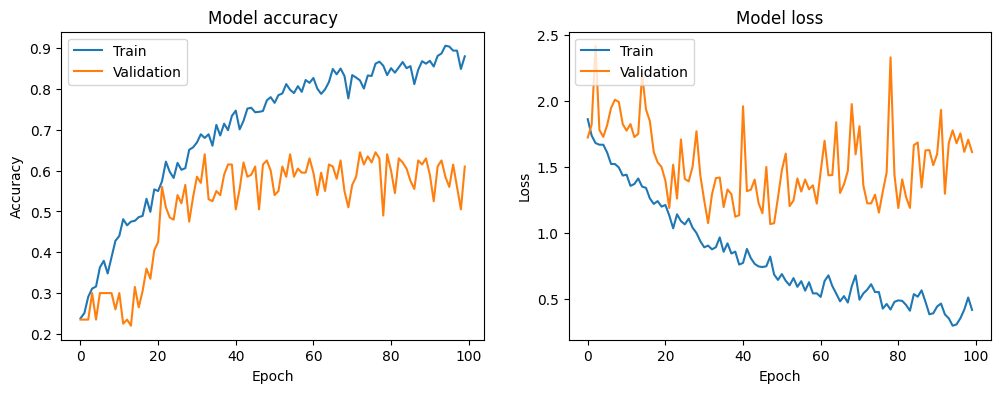

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step


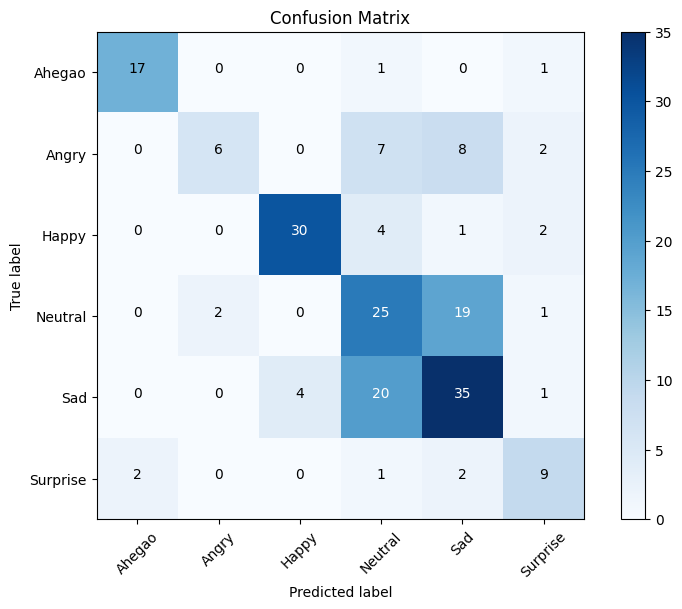

              precision    recall  f1-score   support

      Ahegao       0.89      0.89      0.89        19
       Angry       0.75      0.26      0.39        23
       Happy       0.88      0.81      0.85        37
     Neutral       0.43      0.53      0.48        47
         Sad       0.54      0.58      0.56        60
    Surprise       0.56      0.64      0.60        14

    accuracy                           0.61       200
   macro avg       0.68      0.62      0.63       200
weighted avg       0.64      0.61      0.61       200



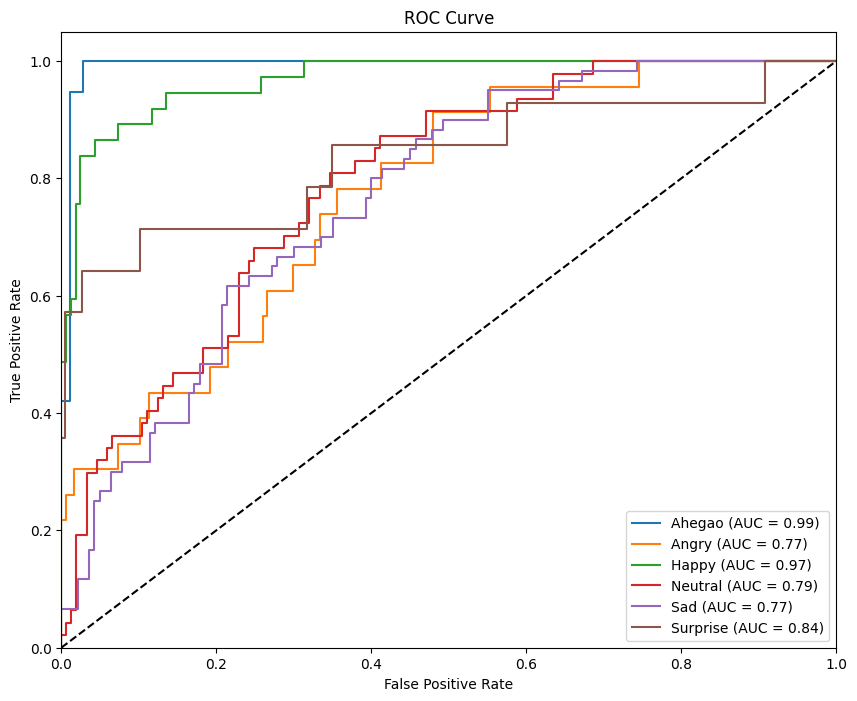

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict the values from the test dataset
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)

# Adding the numbers to the confusion matrix
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'), horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=categories))

# ROC and AUC
y_test_bin = label_binarize(y_test, classes=range(6))
y_pred_bin = label_binarize(y_pred_classes, classes=range(6))

plt.figure(figsize=(10, 8))
for i in range(6):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'{categories[i]} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

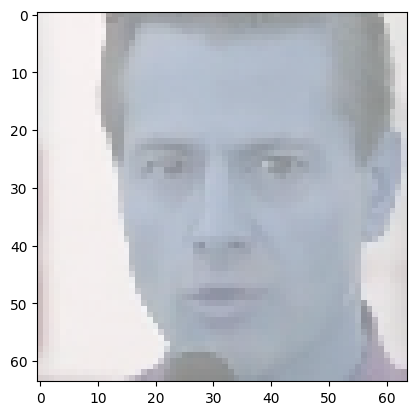

In [ ]:
from lime import lime_image

# Using LIME for interpretability
explainer = lime_image.LimeImageExplainer()

# Select a random image for explanation
sample_image = X_test[0]
explanation = explainer.explain_instance(sample_image, model.predict, top_labels=1, hide_color=0, num_samples=1000)

# Display the explanation
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()